# **Практический урок по блендингу и стекингу**

## **TASK DESCRIPTION**

Датасеты:
- train: https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv

- test: https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv

Регрессионный таргет: столбец target_reg , метрика RMSE.

Для блендинга и стекинга выбрать 3 модели:
- Любые 2 бустинга на ваш выбор.
- Любую другую модель (не бустинг).
- Для стекинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и т. п.).
- Не обязательно выбирать одинаковые тройки, можно для стекинга одни, для блендинга другие 3. Можно использовать модели из предыдущей практики.

Далее реализуем блендинг и стекинг и делаем финальное предсказание:
- можно выбрать предсказание от блендинга;
- можно от стекинга;
- можно ансамбль блендинга и стекинга;
- можно блендинг блендинга и стекинга с весами 🙈.

Главное в этом задании - больше экспериментировать, засылать сабмишены в следующий шаг, проверять скор, подбирать модели и параметры, веса для смешивания. В общем, почувствовать атмосферу чемпионата и долбить гиперпараметры, подбирать модели, веса и смотреть, как падает циферка 🤤. Только у нас попытки не ограничены 5 в день, и можно оторваться по полной.

Дополнительные условия:
- Особенно ничем вас не ограничиваем, можно пользоваться всем арсеналом: подбирать гиперпараметры в Optuna, генерить\отбирать признаки и т. п. Но желательно сосредоточиться на освоении блендинга со стекингом и подбором моделей для них.
- Сохраняем в submission.csv только колонки car_id и target_reg.
В конце добавляем выводы о проделанных экспериментах, что зашло\не зашло.
Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.

Формат сдачи:
- В текстовом поле вводим ссылки на онлайн-версию jupyter ноутбука (GoogleСolab, Kaggle) с выполненным заданием и публичную ссылку на файлхостинг (GoogleDrive, ЯндексДиск или др.) с оригиналом ноутбука (проверяем, что они работают).
- Во вложение добавляем тот же ноутбук, сохраненный в формате pdf с аутпутами всех ячеек (не более 5 Mb).
- В следующем шаге отправляем получившийся CSV-файл с предсказаниями. Можно использовать его как аналог лидерборда, чтобы узнавать скор предсказаний.

## **IMPORT LIBRARIES AND LOAD DATA**

In [ ]:
!pip install optuna xgboost lightgbm catboost shap phik -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, Dataset
import lightgbm as lgb
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb

from tqdm import tqdm
import matplotlib.pyplot as plt
import shap
import phik
from phik.report import plot_correlation_matrix
from phik import report
import optuna

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")
car_id = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")['car_id']

## **EDA**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    1913 non-null   object 
 1   model                     1913 non-null   object 
 2   car_type                  1913 non-null   object 
 3   fuel_type                 1913 non-null   object 
 4   car_rating                1913 non-null   float64
 5   year_to_start             1913 non-null   int64  
 6   riders                    1913 non-null   int64  
 7   year_to_work              1913 non-null   int64  
 8   target_class              1913 non-null   object 
 9   mean_rating               1913 non-null   float64
 10  distance_sum              1913 non-null   float64
 11  rating_min                1913 non-null   float64
 12  speed_max                 1913 non-null   float64
 13  user_ride_quality_median  1913 non-null   float64
 14  deviatio

Отсутствующих данных нет, корреляцию сделаем после feature engineering

## **FEATURE ENGINEERING**

In [ ]:
# генерация нового признака, вычисление возраста автомобиля
train['age_of_car'] = train['year_to_work'] - train['year_to_start']
test['age_of_car'] = test['year_to_work'] - test['year_to_start']

In [ ]:
drop_cols = ['car_id', 'target_reg', 'target_class']
targets = ['target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if(i not in targets and i not in drop_cols)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 12 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'age_of_car']
targets ['target_reg']


In [ ]:
#генерация новых признаков путем умножения и деления всех числовых признаков, позже сделаем фильтрацию
for i in num_features:
  for j in num_features:
    if i != j:
      train[f'{i}/{j}'] = train[i]/train[j]
      train[f'{j}/{i}'] = train[j]/train[i]
      train[f'{i}*{j}'] = train[i]*train[j]
      train[f'{j}*{i}'] = train[j]*train[i]

for i in num_features:
  for j in num_features:
    if i != j:
      test[f'{i}/{j}'] = test[i]/test[j]
      test[f'{j}/{i}'] = test[j]/test[i]
      test[f'{i}*{j}'] = test[i]*test[j]
      test[f'{j}*{i}'] = test[j]*test[i]

In [ ]:
drop_cols = ['car_id', 'target_reg', 'target_class']
targets = ['target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in drop_cols)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

In [ ]:
# фиксируем рандом стейт
RANDOM_STATE = 7575

## **FEATURE SELECTION**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train[filtered_features], train[targets], test_size=0.2, random_state=RANDOM_STATE)

train_dataset = Pool(X_train, y_train, cat_features=cat_features)
val_dataset = Pool(X_val, y_val, cat_features=cat_features)

In [ ]:
# Создаем модель catboost для дальнейшей фильтрации признаков
cb_init_params = {
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

model = CatBoostRegressor(**cb_init_params)
model.fit(train_dataset,
          eval_set=val_dataset,
          verbose=10,
          use_best_model=True)

In [ ]:
# предсказание базовой модели catboost со всеми сгенерированными признаками
mean_squared_error(y_val, model.predict(X_val), squared=False)

11.131521356965855

In [ ]:
# RMSE со всеми сгенерированными признаками на лидерборде - 11.9
pd.DataFrame({'car_id': car_id, 'target_reg': model.predict(test[filtered_features]).reshape(-1)}).to_csv('all_features_base_cb.csv', index=False)

In [ ]:
# Посмотрим на важность признаков с помощью get_feature_importance и отберем больше 0.8
fi = model.get_feature_importance(prettified=True)
fi[fi['Importances']>0.8]

,Feature Id,Importances
0,mean_rating*speed_max,8.850881
1,speed_max*rating_min,6.546937
2,speed_max*mean_rating,4.631237
3,rating_min*mean_rating,4.114436
4,mean_rating/user_uniq,3.340589
5,user_uniq*speed_max,3.217461
6,rating_min*speed_max,2.902545
7,car_type,2.643176
8,mean_rating*rating_min,2.437306
9,mean_rating/speed_max,1.735976


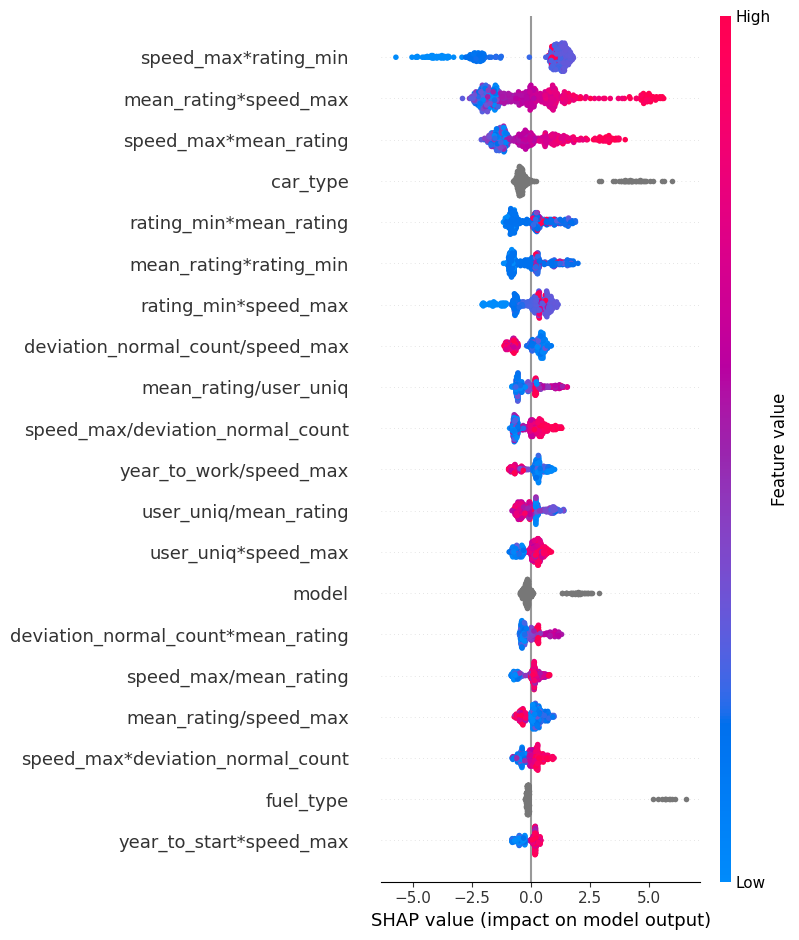

In [ ]:
# Посмотрим на признаки с помощью SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_val)

Видим, что признаки 'mean_rating*speed max', 'rating/user uniq', 'speed max/deviation normal count', 'user uniq*speed max' выделяются, и можно было бы отобрать только их, но я буду использовать все признаки get_feature_importance больше 0.8, так как датафрейм не большой и можно поиграть и с более большим количеством признаков

In [ ]:
# новый список с нужными признаками
new_filtered_features = list(fi[fi['Importances']>0.8]['Feature Id'].values)

In [ ]:
# обновления тренировочного сета и тестового с уже отфильтрованными признаками
train = train[new_filtered_features + targets]
test = test[new_filtered_features]

In [ ]:
drop_cols = ['car_id', 'target_reg']
targets = ['target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in drop_cols)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

interval columns not set, guessing: ['mean_rating*speed_max', 'speed_max*rating_min', 'speed_max*mean_rating', 'rating_min*mean_rating', 'mean_rating/user_uniq', 'user_uniq*speed_max', 'rating_min*speed_max', 'mean_rating*rating_min', 'mean_rating/speed_max', 'deviation_normal_count/speed_max', 'year_to_work/speed_max', 'deviation_normal_count*mean_rating', 'user_uniq/mean_rating', 'speed_max/deviation_normal_count', 'rating_min*year_to_start', 'mean_rating*deviation_normal_count', 'year_to_work/mean_rating', 'year_to_start*mean_rating', 'speed_max/mean_rating', 'rating_min/mean_rating', 'deviation_normal_count*speed_max', 'speed_max/year_to_start', 'target_reg']


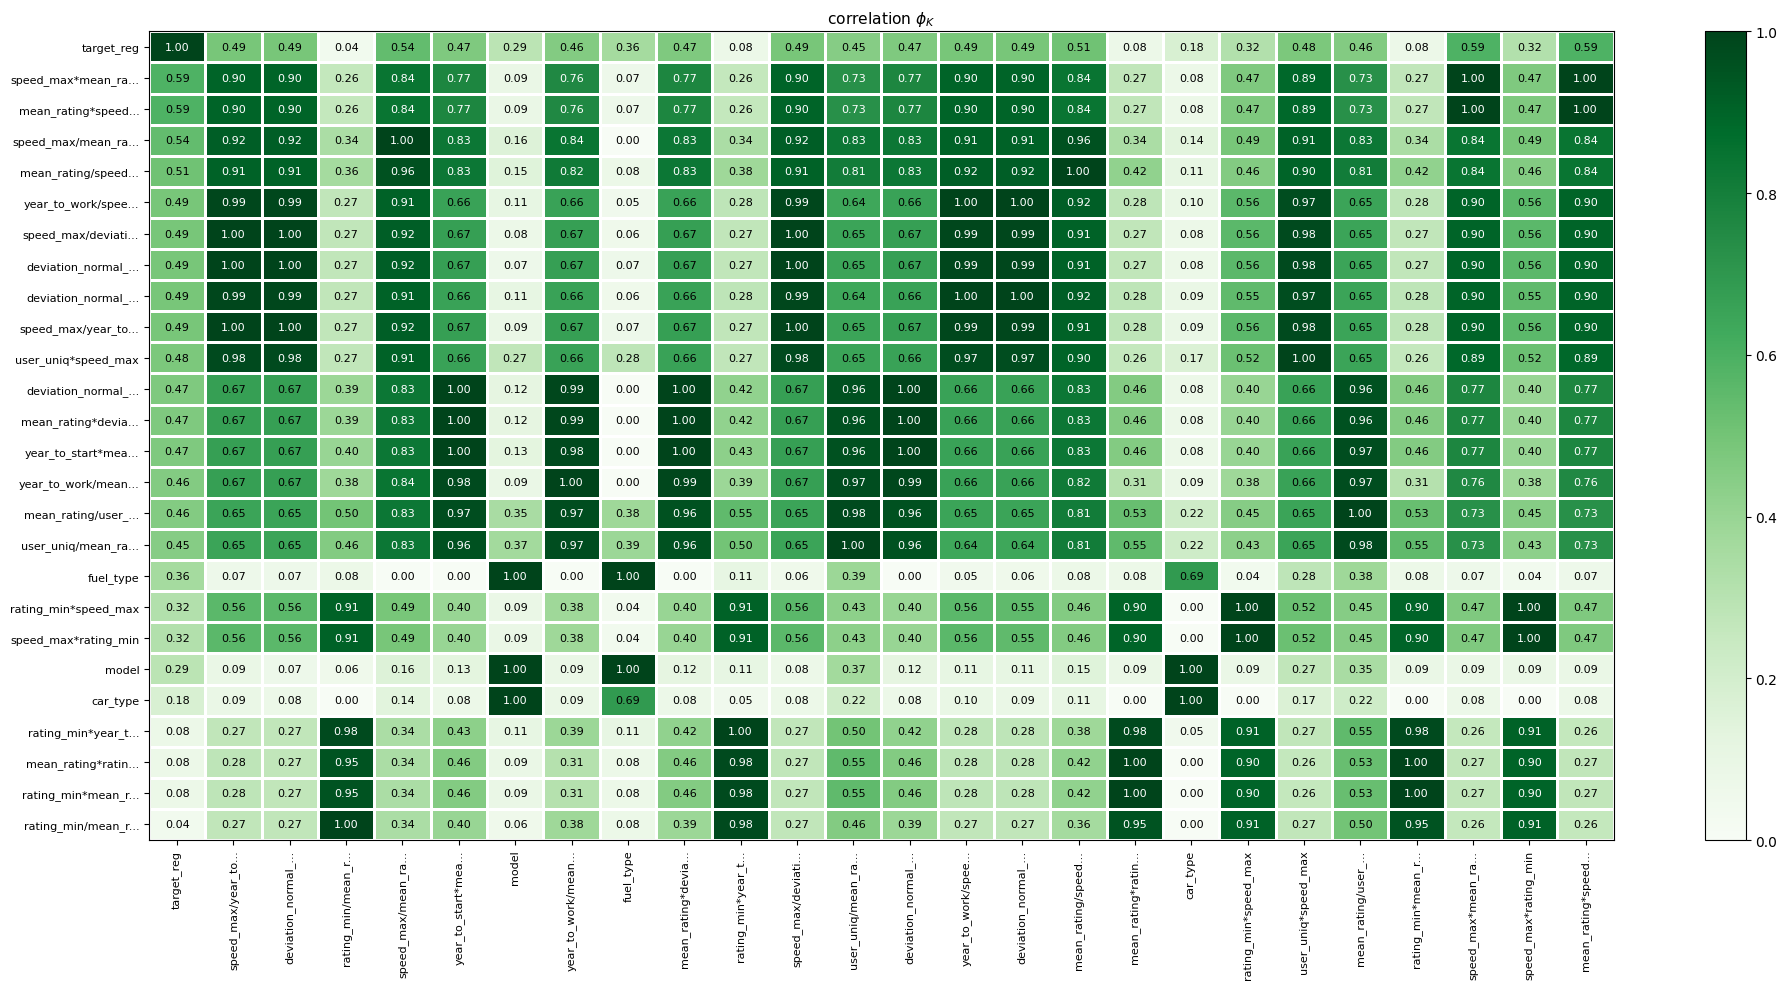

In [ ]:
# Посмотрим на корреляцию при помощи phik
phik_overview = train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(20, 10))
plt.tight_layout()

Находим еще пару колонок, которые практически не коррелируют с целевой переменной. Удаляем их

In [ ]:
train.drop(['rating_min*mean_rating', 'mean_rating*rating_min', 'rating_min/mean_rating', 'rating_min*year_to_start'], axis=1, inplace=True)
test.drop(['rating_min*mean_rating', 'mean_rating*rating_min', 'rating_min/mean_rating', 'rating_min*year_to_start'], axis=1, inplace=True)

In [ ]:
drop_cols = ['car_id', 'target_reg']
targets = ['target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in drop_cols)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

## **PIPELINES**

Создаем пайплайн для обработки числовых и категориальных признаков

In [ ]:
numerical_pipeline = make_pipeline(
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    OrdinalEncoder()
)

In [ ]:
transformer = make_column_transformer(
    (
        numerical_pipeline,
        make_column_selector(dtype_include=['float'])
    ),
    (
        categorical_pipeline,
        make_column_selector(dtype_include=object)
    )
)

transformer

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ef4990e1a20>),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ef4990e2dd0>)])

In [ ]:
# сплит данных на признаки и целевую переменную
X = train[filtered_features]
y = train[targets]

In [ ]:
# трансформируем данные по ранее созданному пайплайну
X = transformer.fit_transform(X)
X_test = transformer.fit_transform(test)

In [ ]:
# преобразуем X и X_test в датафреймы
X = pd.DataFrame(data=X, columns=transformer.get_feature_names_out(), index=train.index)
X_test = pd.DataFrame(data=X_test, columns=transformer.get_feature_names_out(), index=test.index)

## **FIT BASE MODELS**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
# список моделей
lst_base_models = [CatBoostRegressor, LGBMRegressor, XGBRegressor,
                   LinearRegression, KNeighborsRegressor, SVR,
                   RandomForestRegressor, DecisionTreeRegressor,
                   ]
preds = {}
base_models = {}

In [ ]:
# обучим модели без подбора гиперпараметров и посмотрим на предсказания
for mod in tqdm(lst_base_models):

  if mod.__name__ == 'CatBoostRegressor':

    train_dataset = Pool(X_train, y_train)
    val_dataset = Pool(X_val, y_val)
    test_dataset = Pool(X_test)

    init_params = {
        'eval_metric': 'RMSE',
        'thread_count': -1,
        'task_type': 'CPU',
        'random_seed': RANDOM_STATE
    }
    model = mod(**init_params)
    model.fit(train_dataset,
              eval_set=val_dataset,
              verbose=False,
              use_best_model=True)
    preds.update({mod.__name__: mean_squared_error(y_val, model.predict(X_val), squared=False)})
    base_models.update({mod.__name__: model})

  if mod.__name__ == 'LGBMRegressor':

    train_dataset = Dataset(X_train, y_train)
    val_dataset = Dataset(X_val, y_val)
    test_dataset = Dataset(X_test)

    init_params = {
    'objective': 'regression',
    'random_state': RANDOM_STATE,
    'verbosity': -1,
    'device': 'cpu'
    }
    callbacks = [lgb.early_stopping(10, verbose=0), lgb.log_evaluation(period=0)]
    model = lgb.train(params=init_params,
                      train_set=train_dataset,
                      valid_sets=(val_dataset),
                      callbacks=callbacks)
    preds.update({mod.__name__: mean_squared_error(y_val, model.predict(X_val), squared=False)})
    base_models.update({mod.__name__: model})

  if mod.__name__ == 'XGBRegressor':

    train_dataset = xgb.DMatrix(X_train, label=y_train, nthread=-1)
    val_dataset = xgb.DMatrix(X_val, label=y_val, nthread=-1)
    test_dataset = xgb.DMatrix(X_test, nthread=-1)

    init_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': 2,
    'verbosity': 0
    }

    model = xgb.train(params=init_params,
                      dtrain=train_dataset,
                      evals=[(train_dataset, 'dtrain'), (val_dataset, 'dtest')],
                      verbose_eval=False,
                      early_stopping_rounds=25)
    preds.update({mod.__name__: mean_squared_error(y_val, model.predict(val_dataset), squared=False)})
    base_models.update({mod.__name__: model})

  else:
    model = mod().fit(X_train, y_train)
    preds.update({mod.__name__: mean_squared_error(y_val, model.predict(X_val), squared=False)})
    base_models.update({mod.__name__: model})



In [ ]:
# таблица моделей и их предсказания на валидации
pd.DataFrame(preds, index=['models'], columns=preds.keys())

,CatBoostRegressor,LGBMRegressor,XGBRegressor,LinearRegression,KNeighborsRegressor,SVR,RandomForestRegressor,DecisionTreeRegressor
models,11.866399,12.223283,11.842519,12.296778,13.10685,14.932638,11.703681,16.853591


RandomForestRegressor - лучший по предсказаниям, но посмотрим дальше как будут обстоять дела на лидерборде

In [ ]:
lb = {}

In [ ]:
for name, model in base_models.items():
  if name == 'XGBRegressor':
    test_dmatrix = xgb.DMatrix(X_test, nthread=-1)
    pred = model.predict(test_dmatrix).reshape(-1)
    pd.DataFrame({'car_id': car_id, 'target_reg': pred}).to_csv(f'base_{name}.csv', index=False)
    print(name)
    lb.update({name: input()})

  else:
    pred = model.predict(X_test).reshape(-1)
    pd.DataFrame({'car_id': car_id, 'target_reg': pred}).to_csv(f'base_{name}.csv', index=False)
    print(name)
    lb.update({name: input()})

CatBoostRegressor
12.0
LGBMRegressor
12.4
XGBRegressor
12.4
LinearRegression
18.7
KNeighborsRegressor
13.0
SVR
15.0 
RandomForestRegressor
12.2
DecisionTreeRegressor
16.7


In [ ]:
# таблица моделей и их предсказания на лидерборде
pd.DataFrame(lb, index=['models'], columns=lb.keys())

,CatBoostRegressor,LGBMRegressor,XGBRegressor,LinearRegression,KNeighborsRegressor,SVR,RandomForestRegressor,DecisionTreeRegressor
models,12.0,12.4,12.4,18.7,13.0,15.0,12.2,16.7


На этот раз лучшим оказался CatBoostRegressor, немного от него отстали RandomForestRegressor, LGBMRegressor, XGBRegressor. Остальные совсем плохо себя показали

## **OPTUNA**

### CatBoostRegressor

In [ ]:
# создание списка estimators для использования в будущем  при автоматическом стекинге
estimators = []

In [ ]:
def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 4000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.95),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "14gb",
        "eval_metric": "RMSE",
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    clf = CatBoostRegressor(
        **param,
        thread_count=-1,
        random_seed=RANDOM_STATE,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=50,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_cb = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)
valid_scores

# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_cb[0].__class__.__name__, optuna_cb[0]))

In [ ]:
# RMSE=11.8
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_cb[0].predict(X_test)}).to_csv(f'optuna_cb.csv', index=False)

### LGBMRegressor

In [ ]:
def fit_lightgbm(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 32, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.001, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 1024),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective':trial.suggest_categorical('objective', ['rmse']),
        'metric': trial.suggest_categorical('metric', ['rmse']),
        'seed': RANDOM_STATE,
        'boosting_type': trial.suggest_categorical('boosting_type', ["gbdt", "dart", "goss"])
    }


    clf = LGBMRegressor(
        **param,
        thread_count=-1,
        random_seed=RANDOM_STATE,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_lightgbm(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_lgbm = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_lgbm[0].__class__.__name__, optuna_lgbm[0]))

In [ ]:
valid_scores

10.531485487164268

In [ ]:
# RMSE=11.9
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_lgbm[0].predict(X_test)}).to_csv(f'optuna_lgbm.csv', index=False)

### XGBRegressor

In [ ]:
def fit_xgboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'random_state': RANDOM_STATE,
        "objective": "reg:squarederror",
        "eval_metric": 'rmse',
    }


    clf = XGBRegressor(
        **param,
        verbose_eval=0,
        #thread_count=-1,
        random_seed=RANDOM_STATE,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_xgboost(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               #n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_xgb = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

In [ ]:
# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_xgb[0].__class__.__name__, optuna_xgb[0]))

valid_scores

10.633207016253463

In [ ]:
# RMSE=11.8
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_xgb[0].predict(X_test)}).to_csv(f'optuna_xgb.csv', index=False)

### LinearRegression

In [ ]:
# нет подбора гиперпараметров, но можем обучить на разных фолдах
def objective_lr(X, y):
  X, y = X, y
  n_splits = 10
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

  scores, models = [], []

  for train_idx, valid_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]

    clf = LinearRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    scores.append(mean_squared_error(y_pred, y_val, squared=False))
    models.append(clf)
    break


  result = np.mean(scores)
  return result, models

In [ ]:
valid_scores, optuna_lr = objective_lr(X, y)
valid_scores

11.398322857305658

In [ ]:
# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_lr[0].__class__.__name__, optuna_lr[0]))

In [ ]:
# RMSE=19.5
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_lr[0].predict(X_test).reshape(-1)}).to_csv(f'optuna_lr.csv', index=False)

### KNeighborsRegressor

In [ ]:
def fit_knn(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 2, 10),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        "leaf_size": trial.suggest_int("leaf_size", 1, 20),
        'p': trial.suggest_int('p', 1, 2),
        "algorithm": trial.suggest_categorical("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'metric': trial.suggest_categorical('metric', ['euclidean','manhattan'])
    }

    clf = KNeighborsRegressor(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_knn(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_knn = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_knn[0].__class__.__name__, optuna_knn[0]))

valid_scores

11.708388376182326

In [ ]:
# RMSE=12.7
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_knn[0].predict(X_test).reshape(-1)}).to_csv(f'optuna_knn.csv', index=False)

### SVR

In [ ]:
def fit_svr(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'tol': trial.suggest_float('tol', 1e-4, 1e-2),
        'C': trial.suggest_float('C', 0.1, 9),
        'epsilon': trial.suggest_float('epsilon', 0.01, 0.2),
    }

    clf = SVR(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_svr(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_svr = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_svr[0].__class__.__name__, optuna_svr[0]))

valid_scores

10.786104799894487

In [ ]:
# RMSE=12.6
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_svr[0].predict(X_test).reshape(-1)}).to_csv(f'optuna_svr.csv', index=False)

### RandomForestRegressor

In [ ]:
def fit_rfr(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'max_features': trial.suggest_categorical("max_features", ["auto", 'sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 5, 400),
        'criterion': trial.suggest_categorical('criterion', ['squared_error']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'random_state': RANDOM_STATE
    }

    clf = RandomForestRegressor(**param, n_jobs=-1)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_rfr(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_rfr = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_rfr[0].__class__.__name__, optuna_rfr[0]))

valid_scores

10.502787773729752

In [ ]:
# RMSE=12.2
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_rfr[0].predict(X_test)}).to_csv(f'optuna_rfr.csv', index=False)

### DecisionTreeRegressor

In [ ]:
def fit_tree(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {"max_depth": trial.suggest_int("max_depth", 2, 10),
             "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
             "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
             "splitter": trial.suggest_categorical('splitter', ['best','random']),
             "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2']),
             'criterion': trial.suggest_categorical('criterion', ['squared_error']),
             'random_state': RANDOM_STATE
             }

    clf = DecisionTreeRegressor(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = X
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_tree(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_tree = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

# добавляем в список estimators кортеж из имени модели и саму модель с лучшими параметрами
estimators.append((optuna_tree[0].__class__.__name__, optuna_tree[0]))

valid_scores

10.825643321106815

In [ ]:
# RMSE=12.4
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_tree[0].predict(X_test)}).to_csv(f'optuna_tree.csv', index=False)

## BLENDING

### Mean, Median

In [ ]:
# Создаем датафрейм для наглядности как отработали модели при обучении и на лидерборде
scores = pd.DataFrame()

scores['models'] = ['CatBoostRegressor','LGBMRegressor','XGBRegressor','LinearRegression',
                    'KNeighborsRegressor','SVR','RandomForestRegressor', 'DecisionTreeRegressor']

scores['validation'] = [10.4, 10.5, 10.6, 11.4, 11.7, 10.8, 10.5, 10.8]
scores['leaderboard'] = [11.8, 11.9, 11.8, 19.5, 12.7, 12.6, 12.2, 12.4]
scores.sort_values('leaderboard')

,models,validation,leaderboard
0,CatBoostRegressor,10.4,11.8
2,XGBRegressor,10.6,11.8
1,LGBMRegressor,10.5,11.9
6,RandomForestRegressor,10.5,12.2
7,DecisionTreeRegressor,10.8,12.4
5,SVR,10.8,12.6
4,KNeighborsRegressor,11.7,12.7
3,LinearRegression,11.4,19.5


In [ ]:
# Создаем датафрейм со всеми моделями и их предсказаниями для удобного использования при блендинге
preds_models = pd.DataFrame(
{'CatBoostRegressor': pd.read_csv('optuna_cb.csv')['target_reg'],
'LGBMRegressor': pd.read_csv('optuna_lgbm.csv')['target_reg'],
'XGBRegressor': pd.read_csv('optuna_xgb.csv')['target_reg'],
'LinearRegression': pd.read_csv('optuna_lr.csv')['target_reg'],
'KNeighborsRegressor': pd.read_csv('optuna_knn.csv')['target_reg'],
'SVR': pd.read_csv('optuna_svr.csv')['target_reg'],
'RandomForestRegressor': pd.read_csv('optuna_rfr.csv')['target_reg'],
'DecisionTreeRegressor': pd.read_csv('optuna_tree.csv')['target_reg']
}
)
preds_models

,CatBoostRegressor,LGBMRegressor,XGBRegressor,LinearRegression,KNeighborsRegressor,SVR,RandomForestRegressor,DecisionTreeRegressor
0,48.943520,46.492419,53.811283,24.618455,44.228,49.891796,46.737386,47.751319
1,34.126200,32.632942,31.042970,48.128497,36.774,33.758850,32.942189,37.052857
2,31.960382,30.703076,30.729975,40.559920,30.551,28.532165,32.588540,31.442381
3,33.694475,33.679812,34.261723,30.629460,34.916,31.901265,34.422310,33.456603
4,33.395398,31.655817,31.464449,47.695930,35.481,34.451980,32.893333,32.618231
...,...,...,...,...,...,...,...,...
1908,53.486075,53.215935,53.413082,59.360531,57.650,55.070086,57.115797,51.070885
1909,46.981804,43.995789,46.191242,33.135574,50.002,45.864142,46.702792,47.751319
1910,33.603478,33.679812,32.654220,26.163885,33.665,31.252440,34.438389,33.456603
1911,47.035595,45.844691,48.202732,43.285819,55.539,46.930989,47.838098,51.091724


In [ ]:
cols_for_blending = ['CatBoostRegressor',
                     'LGBMRegressor',
                     'XGBRegressor',
                     'LinearRegression',
                    'KNeighborsRegressor',
                     'SVR',
                     'RandomForestRegressor',
                     'DecisionTreeRegressor']

In [ ]:
# блендинг всех моделей по среднему значению и медиане
preds_models['all_mod_mean'] = preds_models[cols_for_blending].mean(axis=1)
preds_models['all_mod_median'] = preds_models[cols_for_blending].median(axis=1)

In [ ]:
# RMSE=12.1
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['all_mod_mean']}).to_csv(f'blend_all_mod_mean.csv', index=False)

In [ ]:
# RMSE=11.8
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['all_mod_median']}).to_csv(f'blend_all_mod_median.csv', index=False)

In [ ]:
cols_for_blending = ['CatBoostRegressor',
                     #'LGBMRegressor',
                     'XGBRegressor',
                     #'LinearRegression',
                    #'KNeighborsRegressor',
                     #'SVR',
                     'RandomForestRegressor',
                     #'DecisionTreeRegressor'
                     ]

In [ ]:
# блендинг 2-моделей бустинга и 1-ой модели случайного леса
preds_models['rf_cb_xgb_mean'] = preds_models[cols_for_blending].mean(axis=1)
preds_models['rf_cb_xgb_median'] = preds_models[cols_for_blending].median(axis=1)

In [ ]:
# RMSE=11.8
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['rf_cb_xgb_mean']}).to_csv(f'rf_cb_xgb_mean.csv', index=False)

In [ ]:
# RMSE=11.8
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['rf_cb_xgb_median']}).to_csv(f'rf_cb_xgb_median.csv', index=False)

### Weight

In [ ]:
# для наглядности, чтобы понимать на какие модели делать ставки при подборе весов
scores[['models', 'leaderboard']].sort_values('leaderboard')

,models,leaderboard
0,CatBoostRegressor,11.8
2,XGBRegressor,11.8
1,LGBMRegressor,11.9
6,RandomForestRegressor,12.2
7,DecisionTreeRegressor,12.4
5,SVR,12.6
4,KNeighborsRegressor,12.7
3,LinearRegression,19.5


In [ ]:
# 3 модели бустинга
preds_models['weight_cb_lgbm_xgb'] = preds_models['CatBoostRegressor'] * 0.45 + preds_models['LGBMRegressor'] * 0.1 + preds_models['XGBRegressor'] * 0.45

In [ ]:
# RMSE=11.7
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['weight_cb_lgbm_xgb']}).to_csv(f'weight_cb_lgbm_xgb.csv', index=False)

С настройкой весов лучших моделей(все бустинги) удалось еще немного улучшить скор

In [ ]:
# 2 модели бустинга и 1 модель случайного леса
preds_models['weight_rf_cb_xgb'] = preds_models['CatBoostRegressor'] * 0.45 + preds_models['XGBRegressor'] * 0.45 + preds_models['RandomForestRegressor'] * 0.1

In [ ]:
# RMSE=11.7
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['weight_rf_cb_xgb']}).to_csv(f'weight_rf_cb_xgb.csv', index=False)

С настройкой весов 2-х моделей бустинга и 1-ой модели случайного леса удалось сохранить лучший скор, прихожу к выводу, что catboost и xgboost тащат, так как случайному лесу добавил маленький вес. Хотя по факту было протестировано много вариантов весов, улучшить скор 11.7 не удалось

## STACKING

### StackingRegressor

In [ ]:
# в качестве мета-модели будем использовать RandomForestRegressor
meta_model = StackingRegressor(
    estimators=estimators,
    #estimators=estimators[1:3]+estimators[5:7],
    # estimators=[estimators[1], estimators[2], estimators[6]],
    #final_estimator=LinearRegression(),
    final_estimator=RandomForestRegressor(n_estimators = 10_000,
                                            max_depth = 5,
                                            verbose=False),
    n_jobs=-1,
    verbose=False,
)

stacking_reg = meta_model
stacking_reg

StackingRegressor(estimators=[('CatBoostRegressor',
                               <catboost.core.CatBoostRegressor object at 0x7ef4962153f0>),
                              ('LGBMRegressor',
                               LGBMRegressor(colsample_bytree=0.8804140864624078,
                                             learning_rate=0.007300362122876599,
                                             max_depth=4, metric='rmse',
                                             min_child_weight=7,
                                             n_estimators=395, num_leaves=57,
                                             objective='rmse', random_seed=7575,
                                             reg_alpha=5.540279980183059,
                                             re...
                                                     min_samples_leaf=10,
                                                     min_samples_split=9,
                                                     n_estimators=19, n_jobs=-1,
                                                     random_state=7575)),
                              ('DecisionTreeRegressor',
                               DecisionTreeRegressor(max_depth=10,
                                                     max_features='sqrt',
                                                     min_samples_leaf=7,
                                                     min_samples_split=4,
                                                     random_state=7575,
                                                     splitter='random'))],
                  final_estimator=RandomForestRegressor(max_depth=5,
                                                        n_estimators=10000,
                                                        verbose=False),
                  n_jobs=-1, verbose=False)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
stacking_reg.fit(X_train, y_train)

StackingRegressor(estimators=[('CatBoostRegressor',
                               <catboost.core.CatBoostRegressor object at 0x7ef4962153f0>),
                              ('LGBMRegressor',
                               LGBMRegressor(colsample_bytree=0.8804140864624078,
                                             learning_rate=0.007300362122876599,
                                             max_depth=4, metric='rmse',
                                             min_child_weight=7,
                                             n_estimators=395, num_leaves=57,
                                             objective='rmse', random_seed=7575,
                                             reg_alpha=5.540279980183059,
                                             re...
                                                     min_samples_leaf=10,
                                                     min_samples_split=9,
                                                     n_estimators=19, n_jobs=-1,
                                                     random_state=7575)),
                              ('DecisionTreeRegressor',
                               DecisionTreeRegressor(max_depth=10,
                                                     max_features='sqrt',
                                                     min_samples_leaf=7,
                                                     min_samples_split=4,
                                                     random_state=7575,
                                                     splitter='random'))],
                  final_estimator=RandomForestRegressor(max_depth=5,
                                                        n_estimators=10000,
                                                        verbose=False),
                  n_jobs=-1, verbose=False)

In [ ]:
# предсказание на валидации
mean_squared_error(y_val, stacking_reg.predict(X_val), squared=False)

11.4872637567537

In [ ]:
# RMSE=12.0
pd.DataFrame({'car_id': car_id, 'target_reg': stacking_reg.predict(X_test)}).to_csv(f'stacking_reg_rf.csv', index=False)

In [ ]:
all_rmse = {}
corr_df = pd.DataFrame()

for model, (name, _) in zip(stacking_reg.estimators_, stacking_reg.estimators):
    preprocessed = stacking_reg.estimators[0][1].fit(X_train, y_train)
    all_rmse.update({name: mean_squared_error(model.predict(X_val), y_val, squared=False)})

    corr_df[name] = model.predict(X_val)

In [ ]:
sorted(all_rmse.items(), key=lambda item: item[1])

[('LGBMRegressor', 11.583247659029201),
 ('SVR', 11.946644052263498),
 ('RandomForestRegressor', 11.995920822745333),
 ('XGBRegressor', 12.038361725486329),
 ('LinearRegression', 12.296778498291168),
 ('CatBoostRegressor', 12.372540850023386),
 ('KNeighborsRegressor', 12.504992191240722),
 ('DecisionTreeRegressor', 12.8759068694909)]

In [ ]:
corr_df.corr().style.background_gradient(cmap="RdYlGn")

,CatBoostRegressor,LGBMRegressor,XGBRegressor,LinearRegression,KNeighborsRegressor,SVR,RandomForestRegressor,DecisionTreeRegressor
CatBoostRegressor,1.000000,0.925319,0.931909,0.787046,0.842165,0.881429,0.886949,0.804040
LGBMRegressor,0.925319,1.000000,0.963540,0.871509,0.886621,0.932554,0.972483,0.875109
XGBRegressor,0.931909,0.963540,1.000000,0.838104,0.867776,0.912875,0.931859,0.865877
LinearRegression,0.787046,0.871509,0.838104,1.000000,0.812863,0.864304,0.837307,0.815932
KNeighborsRegressor,0.842165,0.886621,0.867776,0.812863,1.000000,0.916505,0.873660,0.847376
SVR,0.881429,0.932554,0.912875,0.864304,0.916505,1.000000,0.913694,0.867785
RandomForestRegressor,0.886949,0.972483,0.931859,0.837307,0.873660,0.913694,1.000000,0.877086
DecisionTreeRegressor,0.804040,0.875109,0.865877,0.815932,0.847376,0.867785,0.877086,1.000000


Менее сильно коррелируют LGBMRegressor, SVR, RandomForest, XGB, впринципе и по предсказаниям это лучше видно, оставляю график корреляции всех моделей, так как лучший скор был достигнут лишь 11.9 даже при убранных сильно коррелирующих моделей

In [ ]:
preds_models['stack_lr_lgbm_rf_xgb'] = stacking_reg.predict(X_test)

In [ ]:
# RMSE=11.9
pd.DataFrame({'car_id': car_id, 'target_reg': preds_models['stack_lr_lgbm_rf_xgb']}).to_csv(f'stack_lr_lgbm_rf_xgb.csv', index=False)

### Stacking without extra features

In [ ]:
# Воспользуемся функцией из учебного раздела про стекинг
def GetPreds(model, X, y, X_test, n_fold=5):

    folds = KFold(n_splits=n_fold)
    preds = np.empty((0,1), float)
    df_y = pd.DataFrame(data=y)

    for train_indices, val_indices in folds.split(X, y):
        model.fit(X.iloc[train_indices, :], df_y.iloc[train_indices])
        predictions = model.predict(X.iloc[val_indices, :])
        preds = np.concatenate((preds, predictions), axis=None)

    model.fit(X, y)
    test_preds = model.predict(X_test)
    return preds.reshape(len(X), 1), test_preds.reshape(len(X_test), 1)

In [ ]:
# выбираем 5 моделей хорошо себя показавших при StackingRegression
auto_stacking_models = estimators[:3]+estimators[5:7]

In [ ]:
# создадим датафреймы для сбора предсказаний (валидация и тест)
train_stack_df = y.copy()
test_stack_df = X_test[['pipeline-1__mean_rating*speed_max']].copy()

In [ ]:
# создаем цикл в котором пройдемся по списку 5 успешных моделей и добавим во
# вновь созданные выше датафреймы для сбора предсказаний
for mod in auto_stacking_models:
  train_preds, test_preds = GetPreds(model=mod[1], X=X, y=y, X_test=X_test)
  name = mod[1].__class__.__name__
  train_stack_df[name] = train_preds
  test_stack_df[name] = test_preds

In [ ]:
# убираем лишние колонки в датафреймах
train_stack_df = train_stack_df.iloc[:, 1:]
test_stack_df = test_stack_df.iloc[:, 1:]

#### Staking CatboostRegressor

In [ ]:
def fit_st_no_feat_cb(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 4000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.95),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "14gb",
        "eval_metric": "RMSE",
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    clf = CatBoostRegressor(
        **param,
        thread_count=-1,
        random_seed=RANDOM_STATE,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=50,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = train_stack_df
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_st_no_feat_cb(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_st_no_feat_cb = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

valid_scores

10.2963701193392

In [ ]:
# RMSE=11.8
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_st_no_feat_cb[0].predict(test_stack_df).reshape(-1)}).to_csv(f'optuna_st_no_feat_cb.csv', index=False)

#### Stacking DecisionTreeRegressor

In [ ]:
def fit_st_no_feat_tree(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {"max_depth": trial.suggest_int("max_depth", 2, 10),
             "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
             "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
             "splitter": trial.suggest_categorical('splitter', ['best','random']),
             "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2']),
             'criterion': trial.suggest_categorical('criterion', ['squared_error']),
             'random_state': RANDOM_STATE
             }

    clf = DecisionTreeRegressor(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = train_stack_df
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_st_no_feat_tree(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_st_no_feat_tree = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

valid_scores

10.367573970282846

In [ ]:
# RMSE=12.0
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_st_no_feat_tree[0].predict(test_stack_df).reshape(-1)}).to_csv(f'optuna_st_no_feat_tree.csv', index=False)

#### Staking RandomForestRegressor

In [ ]:
def fit_st_no_feat_rfr(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'max_features': trial.suggest_categorical("max_features", ["auto", 'sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 5, 400),
        'criterion': trial.suggest_categorical('criterion', ['squared_error']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'random_state': RANDOM_STATE
    }

    clf = RandomForestRegressor(**param, n_jobs=-1)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = train_stack_df
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_st_no_feat_rfr(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_st_no_feat_rfr = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

valid_scores

10.090952902490768

In [ ]:
# RMSE=12.0
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_st_no_feat_rfr[0].predict(test_stack_df)}).to_csv(f'optuna_st_no_feat_rfr.csv', index=False)

### Staking with extra features

Feature engineering на основе предсказаний

In [ ]:
# добавим медиану и моду, так как при блендинге они неплохо себя показали
train_stack_df['median'] = train_stack_df.median(axis=1)
train_stack_df['mode'] = train_stack_df.mode(axis=1)

test_stack_df['median'] = test_stack_df.median(axis=1)
test_stack_df['mode'] = test_stack_df.mode(axis=1)

In [ ]:
# добавим умножение и деление признаков
for i in train_stack_df:
  for j in train_stack_df:
    if i != j:
      train_stack_df[f'{i}_div_{j}'] = train_stack_df[i]/train_stack_df[j]
      train_stack_df[f'{i}_mul_{j}'] = train_stack_df[i]*train_stack_df[j]

      test_stack_df[f'{i}_div_{j}'] = test_stack_df[i]/test_stack_df[j]
      test_stack_df[f'{i}_mul_{j}'] = test_stack_df[i]*test_stack_df[j]

Проведем снова при помощи catboost feature selection так как после генерации новых фичей, их стало слишком много

In [ ]:
X_tr, X_v, y_tr, y_v = train_test_split(train_stack_df, y, test_size=0.2, random_state=RANDOM_STATE)

tr_dataset = Pool(X_tr, y_tr)
v_dataset = Pool(X_v, y_v)

In [ ]:
# Создаем модель catboost для дальнейшей фильтрации признаков
cb_init_params_new = {
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

model = CatBoostRegressor(**cb_init_params_new)
model.fit(tr_dataset,
          eval_set=v_dataset,
          verbose=10,
          use_best_model=True)

In [ ]:
# важность признаков
fi = model.get_feature_importance(prettified=True)

In [ ]:
# возьмем признаки, которые больше 1
cols_importance = list(fi[fi['Importances']>1]['Feature Id'].values)

In [ ]:
cols_importance

['mode_mul_median_mul_RandomForestRegressor_mul_XGBRegressor_mul_LGBMRegressor_mul_CatBoostRegressor_mul_RandomForestRegressor',
 'mode_mul_median_div_RandomForestRegressor_div_SVR_mul_XGBRegressor_mul_CatBoostRegressor_mul_SVR',
 'CatBoostRegressor_mul_XGBRegressor',
 'mode_div_median_div_RandomForestRegressor_div_XGBRegressor_mul_LGBMRegressor_mul_median',
 'median_mul_RandomForestRegressor_mul_XGBRegressor_mul_CatBoostRegressor',
 'mode_mul_median_mul_RandomForestRegressor_mul_SVR_mul_LGBMRegressor_mul_CatBoostRegressor',
 'mode_div_median_div_RandomForestRegressor_mul_SVR_mul_XGBRegressor_mul_LGBMRegressor_div_mode',
 'mode_div_RandomForestRegressor_div_LGBMRegressor_mul_CatBoostRegressor_mul_RandomForestRegressor']

#### Stacking CatboostRegressor

In [ ]:
def fit_st_with_feat_cb(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 4000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.95),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "14gb",
        "eval_metric": "RMSE",
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


    clf = CatBoostRegressor(
        **param,
        thread_count=-1,
        random_seed=RANDOM_STATE,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=50,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = train_stack_df[cols_importance]
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_st_with_feat_cb(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_st_with_feat_cb = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

valid_scores

10.269079616722612

In [ ]:
# RMSE=11.9
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_st_with_feat_cb[0].predict(test_stack_df[cols_importance]).reshape(-1)}).to_csv(f'optuna_st_with_feat_cb.csv', index=False)

#### Stacking DecisionTreeRegressor

In [ ]:
def fit_st_with_feat_tree(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {"max_depth": trial.suggest_int("max_depth", 2, 10),
             "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
             "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
             "splitter": trial.suggest_categorical('splitter', ['best','random']),
             "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2']),
             'criterion': trial.suggest_categorical('criterion', ['squared_error']),
             'random_state': RANDOM_STATE
             }

    clf = DecisionTreeRegressor(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = train_stack_df[cols_importance]
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_st_with_feat_tree(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_st_with_feat_tree = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

valid_scores

10.352748546558558

In [ ]:
# RMSE=12.2
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_st_with_feat_tree[0].predict(test_stack_df[cols_importance]).reshape(-1)}).to_csv(f'optuna_st_with_feat_tree.csv', index=False)

#### Stacking RandomForestRegression

In [ ]:
def fit_st_with_feat_rfr(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'max_features': trial.suggest_categorical("max_features", ["auto", 'sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 5, 400),
        'criterion': trial.suggest_categorical('criterion', ['squared_error']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'random_state': RANDOM_STATE
    }

    clf = RandomForestRegressor(**param, n_jobs=-1)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [ ]:
def objective(trial, return_models=False):
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    X_train = train_stack_df[cols_importance]
    y_train = y

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_st_with_feat_rfr(trial, train_data, valid_data)
        scores.append(mean_squared_error(y_pred, valid_data[1], squared=False))
        models.append(model)
        break


    result = np.mean(scores)

    if return_models:
        return result, models
    else:
        return result

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

In [ ]:
valid_scores, optuna_st_with_feat_rfr = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

valid_scores

10.369970047420727

In [ ]:
# RMSE=12.0
pd.DataFrame({'car_id': car_id, 'target_reg': optuna_st_with_feat_rfr[0].predict(test_stack_df[cols_importance])}).to_csv(f'optuna_st_with_feat_rfr.csv', index=False)

## CONCLUSION

In [ ]:
# Создаем датафрейм (модели и предсказания на лидерборде)
scores = pd.DataFrame()

scores['models'] = ['CatBoostRegressor_optuna','LGBMRegressor_optuna','XGBRegressor_optuna','LinearRegression_optuna',
                    'KNeighborsRegressor_optuna','SVR_optuna','RandomForestRegressor_optuna', 'DecisionTreeRegressor_optuna',
                    'CatBoostRegressor_base','LGBMRegressor_base','XGBRegressor_base','LinearRegression_base',
                    'KNeighborsRegressor_base','SVR_base','RandomForestRegressor_base', 'DecisionTreeRegressor_base','BlendingAllModelsMean',
                    'BlendingAllModelsMedian', 'Blending_Cb_Lgbm_Xgb_Weight', 'Blending_Rf_Cb_Xgb_Weight',
                    'StackingRegressor', 'StackingWithoutFeatCatboost', 'StackingWithoutFeatTree', 'StackingWithoutFeatRF',
                    'StackingWithFeatCatboost', 'StackingWithFeatTree', 'StackingWithFeatRF']

scores['leaderboard'] = [11.8, 11.9, 11.8, 19.5, 12.7, 12.6, 12.2, 12.4,
                         12.0, 12.4, 12.4, 18.7, 13.0, 15.0, 12.2, 16.7,
                         12.1, 11.8, 11.7, 11.7, 11.9, 11.8, 12.0, 12.0, 11.9, 12.2, 12.0]


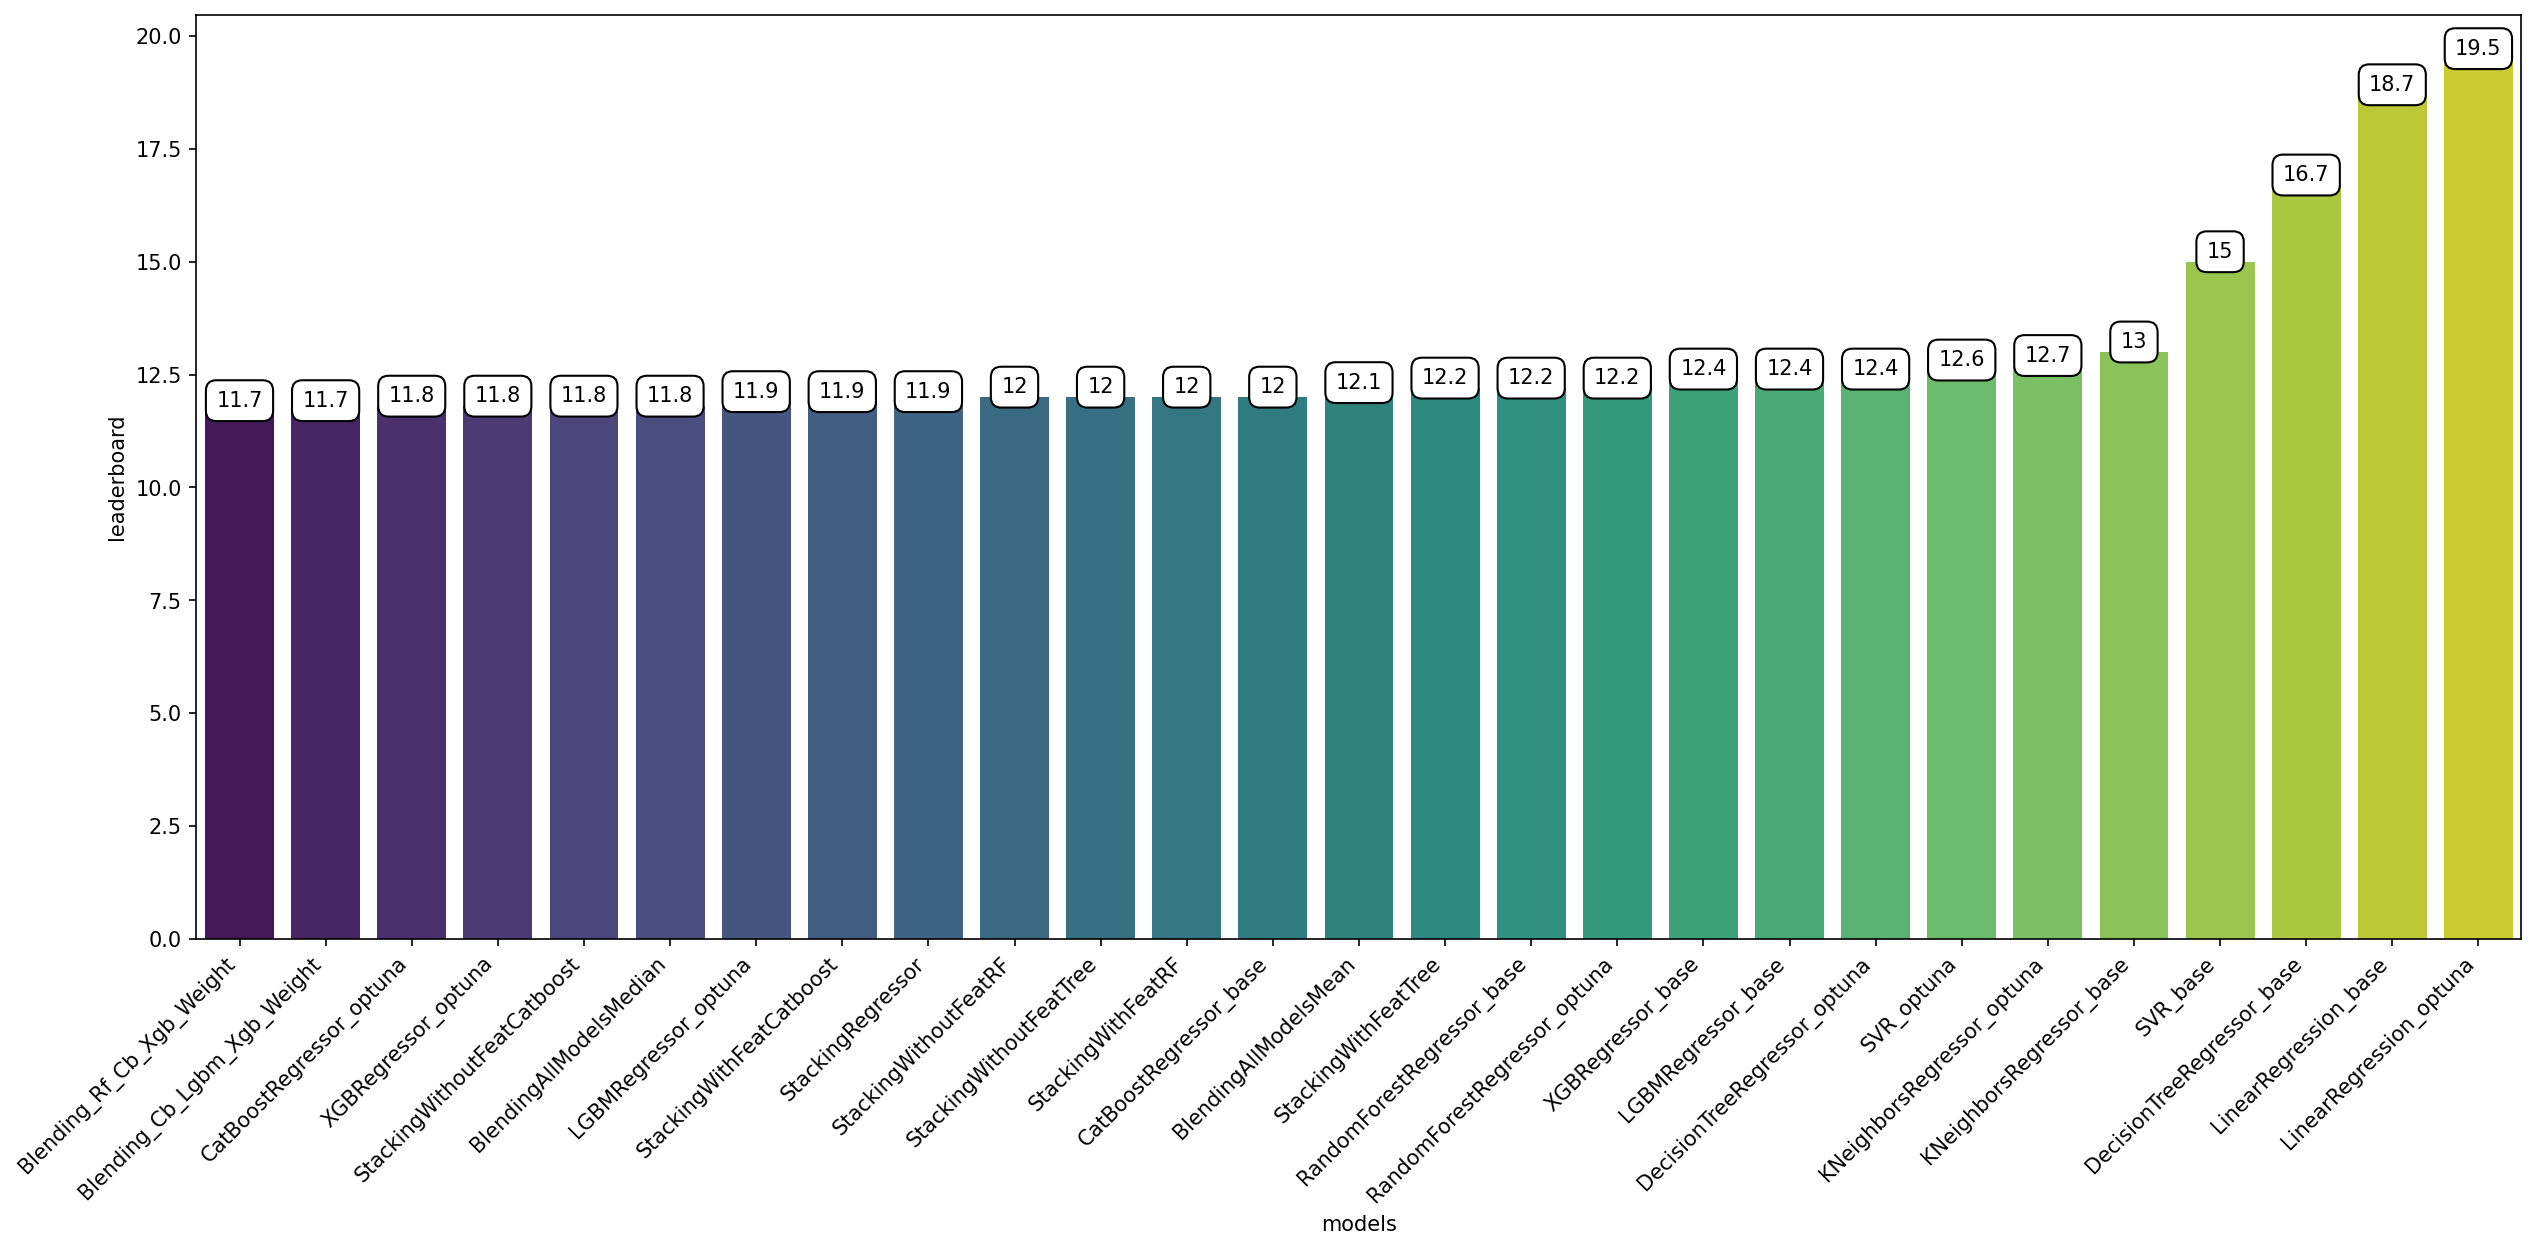

In [ ]:
bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

plt.figure(figsize=(20, 8), dpi=150)
p1 = sns.barplot(scores.sort_values('leaderboard'), y='leaderboard', x='models', palette='viridis')
p1.bar_label(p1.containers[0], bbox = bbox)
plt.xticks(rotation=45, horizontalalignment='right');

**Вывод:**
- Базовая модель CatBoostRegressor показала результат RMSE=12.0, что дало уверенности,что при тюнинге увеличим скор
- RandomForestRegressor дал плохой результат, что в базе, что с тюнингом показывал RMSE=12.2, но в качестве мета модели при StackingRegressor увеличил скор до RMSE=11.9, уже лучше, но все же не дотягивал до пробития порога
- Модели CatBoostRegressor и XGBRegressor при помощи подбора гиперпараметров дали результат в RMSE=11.8, что позволило еще в начале пробить порог RMSE < 11.85
- Стекинг не дал улучшение результата, а в некоторых случаях даже был хуже базовых бустингов, но используя в качестве метамодель catboost и не генерируя новые фичи, удалось сохранить лучший скор RMSE=11.8
- Используя в качестве метамоделей RandomForestRegressor и DecisionTreeRegressor не добился улучшения результата и судя по скору генерация новых фичей ничем не помогла, а даже ухудшила скор
- А вот блендинг при помощи подбора весов позволил улучшить скор, причем при блендинге сразу 3 бустингов скор был равен блендингу 2-х бустингов и 1-ой модели случайного леса, а именно скор составил RMSE=11.7
- Блендинг без подбора весов не улучшал скор, но и не ухудшал, а сохранял на уровне пробития порога RMSE=11.8
- На основании вышеизложенного, в качестве финального предсказания выбираю модель Blending_Rf_Cb_Xgb_Weight

In [ ]:
pd.read_csv('weight_rf_cb_xgb.csv')

,car_id,target_reg
0,P17494612l,50.913400
1,N-1530212S,32.620346
2,B-1154399t,31.469515
3,F12725233R,34.022520
4,l-1139189J,32.476264
...,...,...
1908,x13640960Q,53.816200
1909,Z-2276652N,46.598150
1910,F-2165841B,33.259803
1911,x-1331529J,47.641057
